# Global Flood Validation Metrics Fall 2018 Updates
Written in Python 2

In [3]:
# This notebook was built in Catherine's vectorenv
import pandas as pd
from pandas import DataFrame
import numpy as np
import os
import glob
import datetime
#import pylabb
import matplotlib as plt
import datetime as datetime  
import statsmodels.api as sm  
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('ggplot')

In [4]:
%matplotlib inline

# Data Preparation

In [5]:
path =r'/Users/ckuhn/Desktop/gfd_accuracy_rename/' # use your path
allFiles = glob.glob(path + "/*.csv")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
df = pd.concat(list_)
df = df.drop(['system:index','.geo'], axis=1)

/Users/ckuhn/anaconda2/envs/vectorenv/lib/python3.6/site-packages/ipykernel/__main__.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [6]:
print(len(df['dfoID'].unique()))
df['dfoID'].unique()

117


array([2948, 3166, 2183, 1818, 4218, 3625, 3657, 2458, 2444, 2640, 1910,
       4346, 4188, 3198, 3544, 4258, 4314, 4211, 3673, 2180, 3567, 2206,
       2075, 4163, 4435, 2461, 4179, 2599, 3179, 4339, 4444, 2586, 4340,
       3658, 2543, 2597, 1641, 4464, 4171, 3678, 2947, 2940, 2024, 3162,
       3132, 3696, 3464, 3274, 2780, 4272, 1971, 4226, 2584, 2099, 2076,
       3871, 3205, 3094, 1810, 3846, 4024, 4019, 2395, 2167, 2345, 3916,
       4325, 2829, 4159, 2688, 2214, 3366, 4115, 4241, 2443, 2570, 1925,
       2269, 3365, 2104, 4516, 4022, 3123, 2296, 1931, 3572, 4098, 2629,
       3267, 3786, 3850, 3070, 3754, 2261, 4357, 2463, 2191, 3476, 2711,
       3977, 4428, 4427, 4315, 3692, 2216, 3856, 4364, 2119, 2332, 2832,
       3218, 3931, 2177, 2366, 3345, 2821, 4507])

### Strata 

The points were stratified into three classes or strata. They are 50% not flooded (permanent water + dry) and 50% flooded. 
- not flooded/dry (0)
- permanent water (1)
- flooded (2)

In [7]:
df.groupby(['strata'])['dfoID'].count()
# strata = 0 = dry, 1 = permanent water, 2 = flood

strata
0     7231
1     7106
2    15093
Name: dfoID, dtype: int64

#### Drop all the no data values

In [8]:
# Pixels got labeled "NAN" were coded as either -99 or 99 
df.groupby(['validation'])['dfoID'].count()

validation
-99.0     1338
 0.0     10215
 1.0     16550
 99.0      507
Name: dfoID, dtype: int64

In [9]:
df = df.loc[df['validation']> -1]
df = df.loc[df['validation']<99]
df.groupby(['validation'])['dfoID'].count()

validation
0.0    10215
1.0    16550
Name: dfoID, dtype: int64

### Prepare Inputs for Confusion Matrix

In [10]:
df['strata'] = df['strata'].multiply(2)
df['strata'].value_counts()
# 0 - dry, 2 - permanent water - 4 - floods

4    13692
0     6618
2     6455
Name: strata, dtype: int64

In [11]:
# 0 - dry, 1 - flooded
df['validation'].value_counts()

1.0    16550
0.0    10215
Name: validation, dtype: int64

In [12]:
# Add them together
df['score']  = df['strata'] + df['validation'] 

### Check number of sampled points

Text(0.5,1,'')

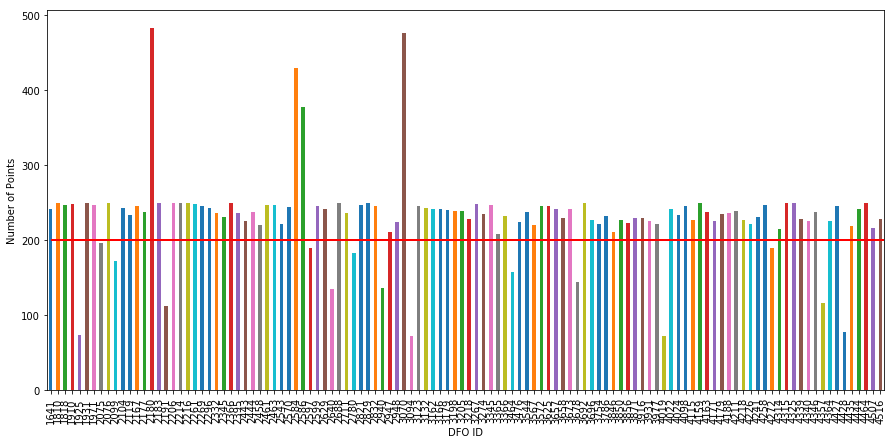

In [13]:
# Check the number of points for each flood
fig, ax = plt.subplots(figsize=(15,7))
df.groupby(['dfoID']).count()['score'].plot(ax=ax, kind='bar')
ax.hlines(y=200, xmin=0, xmax=117, linewidth=2, color='r')
ax.set_ylabel('Number of Points')
ax.set_xlabel('DFO ID')
ax.set_title('')

### Drop the floods with fewer than 200 points

In [14]:
df2 = df.groupby('dfoID').filter(lambda g: g.dfoID.count() > 200)
df2.dfoID.unique()

array([2948, 3166, 2183, 1818, 4218, 3625, 3657, 2458, 2444, 1910, 4346,
       4188, 3198, 3544, 4258, 4314, 4211, 3673, 2180, 3567, 2206, 4163,
       4435, 2461, 4179, 2599, 3179, 4339, 4444, 2586, 4340, 3658, 2543,
       1641, 4464, 4171, 2947, 3162, 3132, 3696, 3274, 1971, 4226, 2584,
       2076, 3871, 3205, 1810, 3846, 4024, 2395, 2167, 2345, 3916, 4325,
       2829, 4159, 2688, 2214, 3366, 4115, 4241, 2443, 2570, 2269, 3365,
       2104, 4516, 4022, 3123, 2296, 1931, 3572, 4098, 2629, 3267, 3786,
       3850, 3070, 3754, 2261, 2463, 3476, 2711, 3977, 4427, 4315, 3692,
       2216, 3856, 4364, 2119, 2332, 2832, 3218, 3931, 2177, 2366, 3345,
       2821, 4507])

In [15]:
p = df.groupby('dfoID').filter(lambda g: g.dfoID.count() < 200)
p.dfoID.unique()

array([2640, 2075, 2597, 3678, 2940, 3464, 2780, 4272, 2099, 3094, 4019,
       1925, 4357, 2191, 4428])

### Export Master csv

In [ ]:
#%cd '/Users/ckuhn/Desktop/gfd_accuracy_rename/lumped/'
#df2.to_csv('all_student_data.csv', encoding='utf-8')

### Calculate matrix components

**Validation** = student classification  
** Strata** = DFO classification

- true positive = Validation (1) + Strata(4) = 5
- true negative = Validation (0) + Strata (0) =  0 
- false positive = Validation (0) + Strata (4) = 4
- false negative = Validation (1) + Strata (0) = 1

In [16]:
# The new 'score' column has values that will indicate tn, tp, fn, fp
df2['score'].value_counts()

5.0    9895
0.0    5602
3.0    5332
4.0    2995
2.0     618
1.0     293
Name: score, dtype: int64

In [17]:
# Filter to the scores of interest (excludes permanent water category)
q = (df2.loc[df2['score']!= 2]) # permanent water
q = (q.loc[q['score']!= 3]) 
q['score'].value_counts()

#5 = true positive, 4 = true negative, 1 - false negative, 0 = true negative

5.0    9895
0.0    5602
4.0    2995
1.0     293
Name: score, dtype: int64

Text(0,0.5,'Average NDVI')

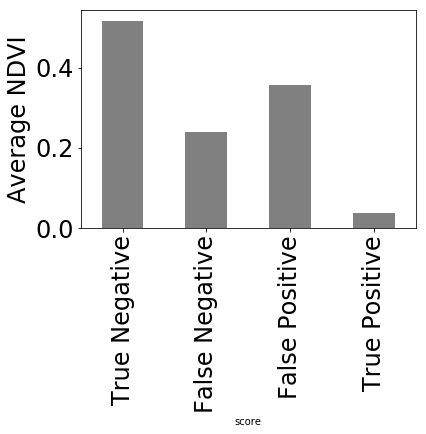

In [18]:
 params = {'axes.titlesize':'32',
          'xtick.labelsize':'24',
          'ytick.labelsize':'24'}
plt.rcParams.update(params)


q.groupby(['score'])['NDVI'].mean().plot(kind='bar', color='grey')
plt.xticks([0, 1, 2, 3], ['True Negative', 'False Negative', 'False Positive', 'True Positive'])
plt.ylabel('Average NDVI', fontsize=24)

# Metrics By Each Event

In [19]:
raw = df2.copy()
raw.shape

(24735, 18)

In [20]:
y_act = raw['strata']
y_pred = raw['validation'] 
df_confusion = pd.crosstab(y_act, y_pred)
df_confusion

validation,0.0,1.0
strata,,
0,5602,293
2,618,5332
4,2995,9895


### Set the plotting style to make fonts big for a talk

In [21]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 50)
    
set_style()  

### Define the four components of the confusion matrix

In [22]:
#Validation (1) + Strata (4)
tp = len(raw.loc[raw['score']== 5])
#Validation (0) + Strata (0)
tn = len(raw.loc[raw['score']== 0])
#Validation (0) + Strata (4)
fp = len(raw.loc[raw['score']== 4])
#Validation (1) + Strata (0)
fn = len(raw.loc[raw['score']== 1])

### Create a function to plot the matrix

/Users/ckuhn/Desktop/gfd_accuracy_rename/figures


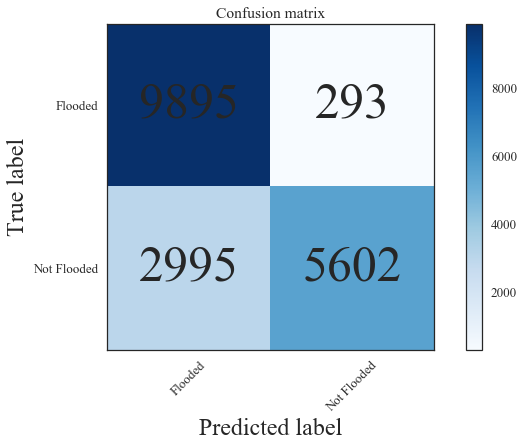

In [23]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label', fontsize=24)
    plt.xlabel('Predicted label',  fontsize=24)

    tp,
cm = np.array([[tp, fn],[fp, tn]])
plot_confusion_matrix(cm, ['Flooded', 'Not Flooded'])

%cd /Users/ckuhn/Desktop/gfd_accuracy_rename/figures
plt.savefig('GFD_overall_confusion_matrix_Sep2018.png', dpi = 300)

In [24]:
total = tn+tp+fn+fp
print('True Negatives(%)',tn/total) #32   Sep 2018 updates: 30%
print('True Positives(%)',tp/total) #52   Sep 2018 updates: 52%
print('False Positives(%)',fp/total) #15  Sep 2018 updates: 16%
print('False Negatives(%)',fn/total) # <0.01  Sep 2018 updates: 1.6%

True Negatives(%) 0.2982166622305031
True Positives(%) 0.526750066542454
False Positives(%) 0.15943571998935321
False Negatives(%) 0.015597551237689645


## Calculate Summarized Error Metrics By Flood

In [25]:
floods = list(set(raw.dfoID)) ## Get a list of all the unique values of floods

In [26]:
floods = list(set(raw.dfoID)) ## Get a list of all the unique values of floods
sampling_levels = np.arange(0, 200, 1)

col_names =  ['Flood','NumofPoints', 'tp', 'tn','fp','fn',
             'precision','recall','overall_accuracy',
             'commission','omission'] ### Column names for making data frames for each flood
my_df  = pd.DataFrame(columns = col_names)## Make empty data frame to put values for each sampling level in

for i in floods:  ### Loop through floods
    df_full = raw.loc[raw['dfoID']== i] ### subset data frame by single flood
    for j in sampling_levels: ## Loop through sampling levels
        df = df_full.sample(j) ##Apparently pandas has a built-in dataframe random sampler!
        tp = float(len(df.loc[df['score']== 5])) 
        tn = float(len(df.loc[df['score']== 0]))
        fp = float(len(df.loc[df['score']== 4]))
        fn = float(len(df.loc[df['score']== 1]))
        ### Calculating values!
        if tp == 0: ###Hmm, sometimes there are no tp scores, so you get a zero divide error
            continue ###I've put this in for now but it's gonna bite your butt eventually
        precision = tp / (tp + fp)
        recall  = tp / (tp + fn)  # % of flooded pixels it ID'ed correctly
        accuracy = (tn + tp) / (tn+tp+fp+fn)
        commission = fp / (tp + fp)  # modeled positives over all true positives
        omission = fn / (tp + fn)
        ##add a new row to the dataframe based on this sampling level!
        my_df.loc[len(my_df)] = [i,j, tp, tn, fp, fn, precision, recall, accuracy, commission, omission]

        ###Now you should have a full dataframe with all your sampling levels for each flood
        ###SO
        
#Export Results
#%cd '/Users/ckuhn/Desktop/gfd_accuracy_rename/lumped/'
#Anna's original - my_df.to_csv('myprecious.csv', encoding='utf-8')
#my_df.to_csv('gfd_summary_validaton_metrics_resampled.csv', encoding='utf-8')

In [27]:
my_df.head()

,Flood,NumofPoints,tp,tn,fp,fn,precision,recall,overall_accuracy,commission,omission
0,4098.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1,4098.0,3.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
2,4098.0,4.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
3,4098.0,5.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
4,4098.0,6.0,2.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [48]:
my_df.overall_accuracy.mean()

0.8277761465495562

### Sub-set resampled floods to just the ones with 200 points

In [28]:
# Extract the dataframes with 200 points
my_df = my_df.loc[my_df['NumofPoints'] == 199]

# Drop the one garbage dataframe
#my_df = my_df.loc[my_df['Flood'] != 'SiL']

len(my_df)

101

In [29]:
# Recast as an integer
my_df['Flood'] = my_df['Flood'].astype(int)

# Export results
%cd '/Users/ckuhn/Desktop/gfd_accuracy_rename/lumped/'
my_df.to_csv('gfd_summary_validaton_metrics.csv', encoding='utf-8')  #aka my_df.to_csv('myprecious3.csv', encoding='utf-8')

/Users/ckuhn/Desktop/gfd_accuracy_rename/lumped


In [30]:
my_df.head(1)

,Flood,NumofPoints,tp,tn,fp,fn,precision,recall,overall_accuracy,commission,omission
197,4098,199.0,91.0,50.0,6.0,2.0,0.938144,0.978495,0.946309,0.061856,0.021505


### Prep Data for Export to Long Form

In [ ]:
prepped = my_df.copy()     
prepped.rename(columns={'tp': 'True Positive', 'fp': 'False Positive', 'fn':'False Negative', 'tn': 'True Negative', 'overall_accuracy':'Overall Accuracy', 'commission':'Commission', 'omission':'Omission', 'precision':'Precision', 'recall':'Recall'}, inplace=True)

In [ ]:
dfmelted = prepped.melt(id_vars=['Flood', 'NumofPoints'], var_name='Metric')
dfmelted.head(1)

In [ ]:
# Export results
%cd '/Users/ckuhn/Desktop/gfd_accuracy_rename/lumped/'
dfmelted.to_csv('gfd_summary_validaton_metrics_longform.csv', encoding='utf-8')  #aka my_df.to_csv('myprecious3.csv', encoding='utf-8')

### Analyze results

In [31]:
# 59 floods

print('% of Floods with >90% accuracy', (len(my_df.loc[my_df['overall_accuracy'] >= 0.9]))/len(my_df))
print('% of Floods with >75% accuracy', (len(my_df.loc[my_df['overall_accuracy'] >= 0.75]))/len(my_df))
my_df['overall_accuracy'].describe()

# For 59 floods, mean accuracy is 82%, median accuracy is 86%, 75% of floods have 94% accuracy
    # 41% of the floods have 90% or better accuracy 
    # 73% of the flood have 80% or better accuracy 
# for 37 floods:  mean accuracy is 85%, median accuracy is 89%, 75% of the floods have 92% accuracy. 
    # and 49% of the floods have 90% or better accuracy 
    # 78% of the flood have 80% or better accuracy 

% of Floods with >90% accuracy 0.44554455445544555
% of Floods with >75% accuracy 0.7524752475247525


count    101.000000
mean       0.827776
std        0.151572
min        0.340136
25%        0.759494
50%        0.861842
75%        0.946309
max        1.000000
Name: overall_accuracy, dtype: float64

### Errors of Commission

In [32]:
my_df['commission'].mean()

#From 37 floods: 0.22182899539761314
#From 59 floods: 0.25010345838907294

0.22714918301064266

/Users/ckuhn/Desktop/gfd_accuracy_rename/figures


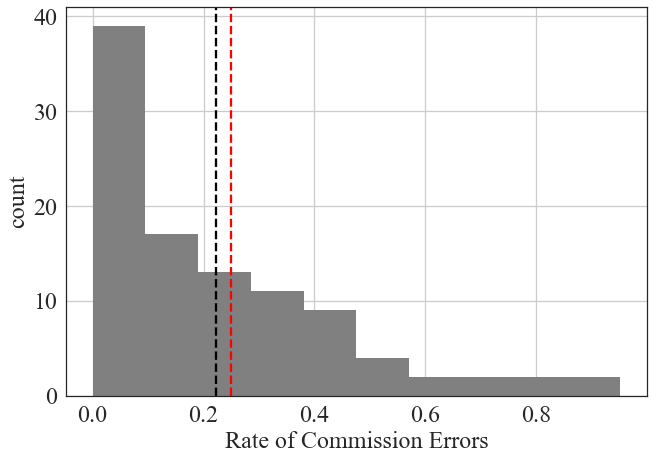

In [33]:
params = {'axes.titlesize':'32',
          'xtick.labelsize':'24',
          'ytick.labelsize':'24'}
plt.rcParams.update(params)

# Go back to normal
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)  # to revert to default settings


my_df['commission'].hist(color='grey')
plt.ylabel('count', fontsize=24)
plt.xlabel('Rate of Commission Errors', fontsize=24)

plt.axvline(x=0.22182899539761314, color='black', ls='--')
plt.axvline(x=0.25010345838907294, color='red', ls='--')

# mean errors of commission is 25%, 

%cd /Users/ckuhn/Desktop/gfd_accuracy_rename/figures/
plt.savefig('GFD_overall_commission.png', dpi = 300)

### Errors of Omission

In [34]:
my_df['omission'].mean()

#From 37 floods: 0.02238782782112279
#From 59 floods: 0.022641702349266005

0.026170482621217097

/Users/ckuhn/Desktop/gfd_accuracy_rename/figures


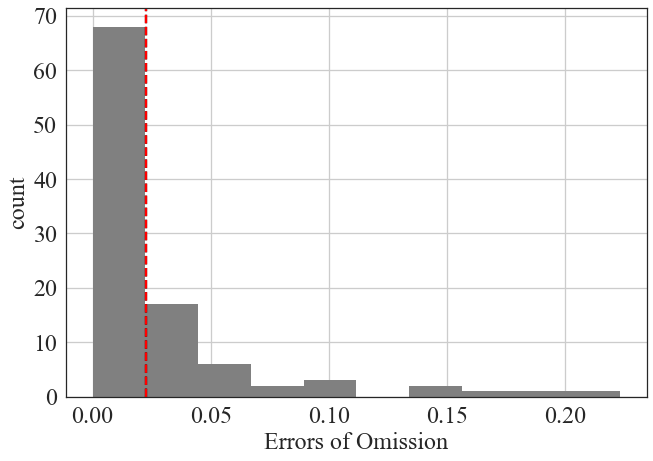

In [35]:
my_df['omission'].hist(color='grey')
plt.ylabel('count', fontsize=24)
plt.xlabel('Errors of Omission', fontsize=24)
plt.axvline(x=0.02238782782112279, color='black', ls='--')
plt.axvline(x=0.022641702349266005, color='red', ls='--')

%cd /Users/ckuhn/Desktop/gfd_accuracy_rename/figures
plt.savefig('GFD_overall_omission.png', dpi = 300)

/Users/ckuhn/Desktop/gfd_accuracy_rename/figures


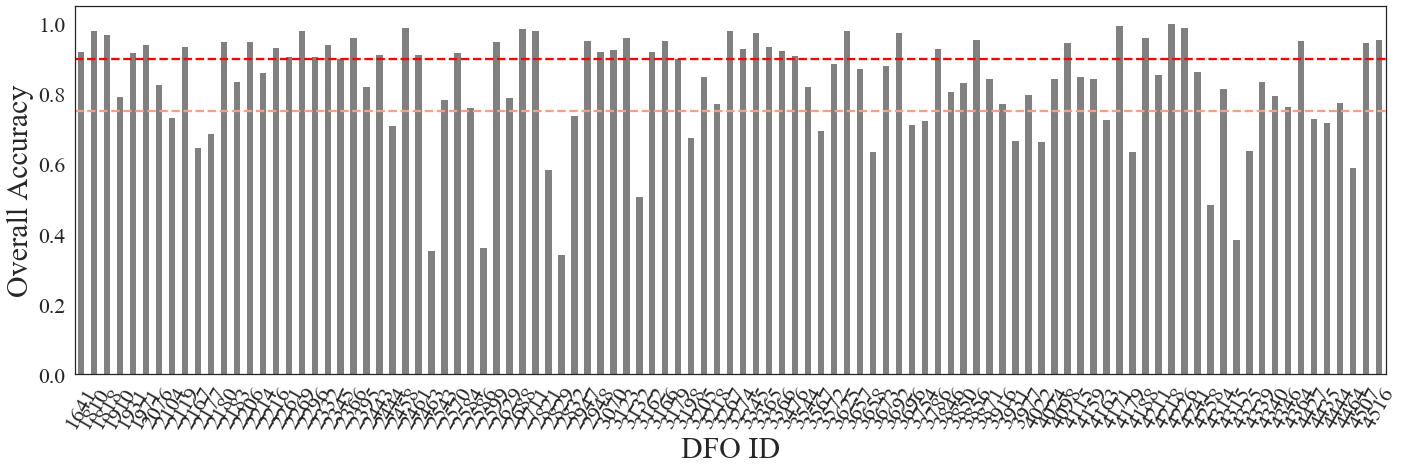

In [36]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 22)
    plt.rc('xtick', labelsize=22) 
    plt.rc('ytick', labelsize=22) 
set_style()  

fig, ax = plt.subplots(figsize=(20,7))

my_df.groupby(['Flood'])['overall_accuracy'].mean().plot(kind='bar', color='grey')
plt.ylabel('Overall Accuracy', fontsize = 30)
plt.xlabel('DFO ID', fontsize = 30)
plt.axhline(y=0.9, color='red', ls='--')
plt.axhline(y=0.75, color='#FFA07A', ls='--')

plt.xticks(rotation=60)

plt.tight_layout()

%cd /Users/ckuhn/Desktop/gfd_accuracy_rename/figures/
plt.savefig('GFD_overall_accuracy_by_flood.png', dpi = 300)

/Users/ckuhn/Desktop/gfd_accuracy_rename/figures


<Figure size 2880x864 with 0 Axes>

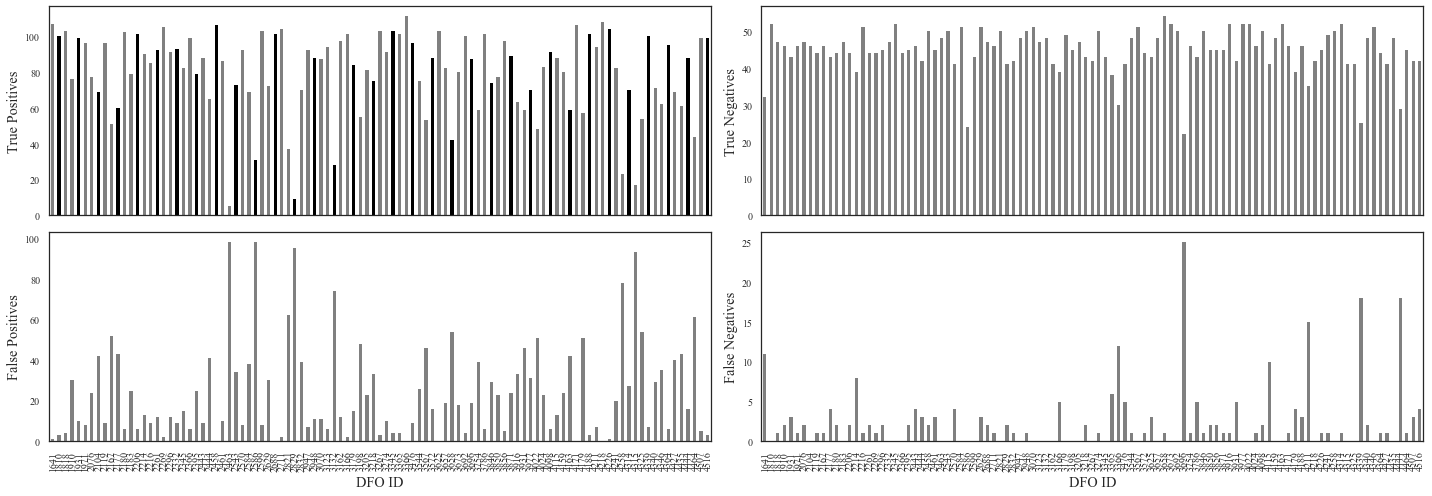

In [37]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 10)
    plt.rc('xtick', labelsize=10) 
    plt.rc('ytick', labelsize=10) 
set_style()  

plt.figure(figsize=(40, 12))


fig, ax = plt.subplots(2, 2, figsize=(20,7))

my_df.groupby(['Flood'])['tp'].mean().plot(kind='bar', color = 
                                                              ['grey', 'black'], ax = ax[0,0])
ax[0, 0].set_ylabel('True Positives')
ax[0, 0].set_xlabel('')
ax[0, 0].set_xticklabels([])

my_df.groupby(['Flood'])['tn'].mean().plot(kind='bar', color = 'grey', ax=ax[0, 1])
ax[0, 1].set_ylabel('True Negatives')
ax[0, 1].set_xlabel('')
ax[0, 1].set_xticklabels([])

my_df.groupby(['Flood'])['fp'].mean().plot(kind='bar', color = 'grey', ax=ax[1, 0])
ax[1, 0].set_ylabel('False Positives')
ax[1, 0].set_xlabel('DFO ID')

my_df.groupby(['Flood'])['fn'].mean().plot(kind='bar', color = 'grey', ax=ax[1, 1])
ax[1, 1].set_ylabel('False Negatives')
ax[1, 1].set_xlabel('DFO ID')

plt.tight_layout()

%cd /Users/ckuhn/Desktop/gfd_accuracy_rename/figures/
plt.savefig('GFD_base_metrics_by_flood.png', dpi = 300)

In [38]:
%cd /Users/ckuhn/Desktop/gfd_accuracy_rename/lumped/
test = pd.read_csv('gfd_summary_validaton_metrics_longform.csv', low_memory=False)
test.groupby(['Metric'])['value'].mean()

/Users/ckuhn/Desktop/gfd_accuracy_rename/lumped


Metric
Commission           0.228202
False Negative       2.336634
False Positive      23.801980
Omission             0.026852
Overall Accuracy     0.827381
Precision            0.771798
Recall               0.973148
True Negative       45.029703
True Positive       79.980198
Name: value, dtype: float64

In [39]:
test.head(1)

,Unnamed: 0,Flood,NumofPoints,Metric,value
0,0,4098,199.0,True Positive,101.0


In [40]:
error = test.loc[test['Metric'].isin(['Commission','Omission'])]
overall = test.loc[test['Metric'].isin(['Overall Accuracy','Precision','Recall' ])]
basics = test.loc[test['Metric'].isin(['True Positive','True Negative','False Positive', 'False Negative' ])]

In [41]:
test.Metric.unique()

array(['True Positive', 'True Negative', 'False Positive',
       'False Negative', 'Precision', 'Recall', 'Overall Accuracy',
       'Commission', 'Omission'], dtype=object)

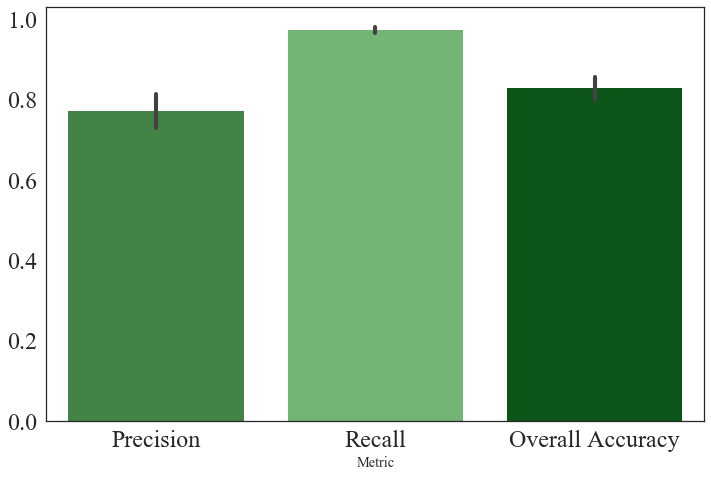

In [42]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 24)
    
set_style()    

ax = sns.barplot(y="value", x="Metric", palette= ['#388e3c', '#6abf69', '#00600f'],   data=overall)
ax.set_ylabel('')
ax.tick_params(labelsize=24)
ax.set_title('')
plt.tight_layout()
plt.show()

/Users/ckuhn/Desktop/gfd_accuracy_rename/figures


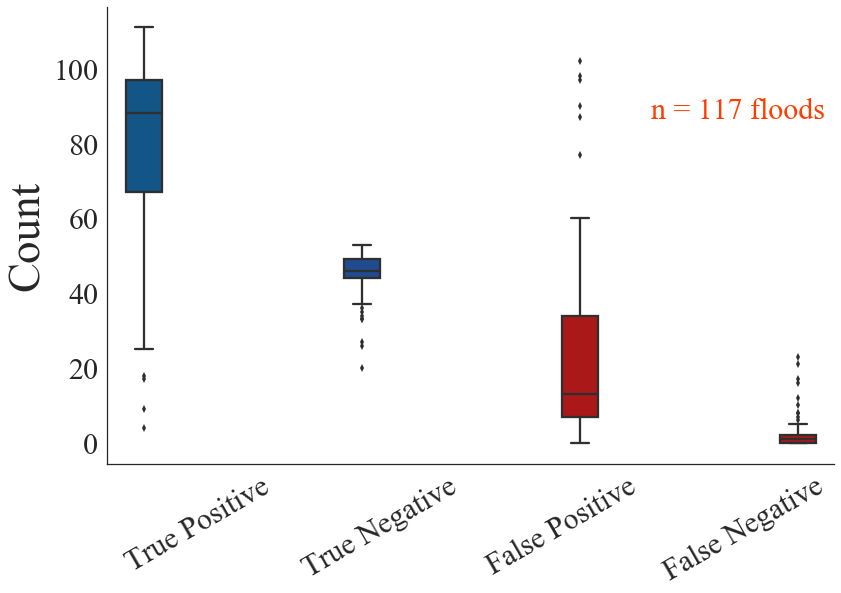

In [43]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 30)
    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=30) 
set_style()  

order = 'True Positive', 'True Negative', 'False Negative', 'False Positive'

g = sns.factorplot(kind='box',        # Boxplot
               y='value',       # Y-axis - values for boxplot
               x='Metric',        # X-axis - first factor
               hue = 'Metric',
               #order= metric,
               data=basics,        # Dataframe 
               size=8,            # Figure size (x100px)      
               aspect=1.5, 
               palette= ['#01579b', '#0d47a1', '#c30000', '#c30000'],  # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot
#g.fig.get_axes()[0].set_yscale('log')

g.fig.text(0.75, 0.75,'n = 117 floods', fontsize=30, color = '#ff3d00') #add text

g.set_xticklabels(rotation=30)

plt.ylabel('Count', fontsize = 45)
plt.xlabel('', fontsize = 45)
plt.title('', fontsize = 45)
#plt.axhline(y=0, color='grey', ls='--')
#plt.legend(loc='upper left', fontsize=45)

%cd /Users/ckuhn/Desktop/gfd_accuracy_rename/figures/
plt.savefig('GFD_basics.png', dpi = 300)

plt.show()

#http://queirozf.com/entries/matplotlib-pyplot-by-example#change-tick-label-rotation # ADD LABELS

/Users/ckuhn/Desktop/gfd_accuracy_rename/figures


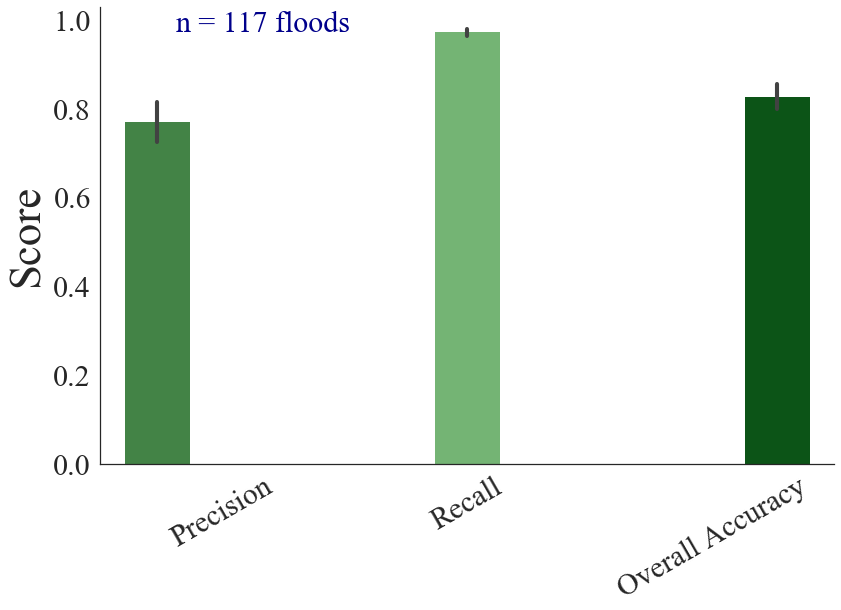

In [44]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 30)
    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=30) 
set_style()  


g = sns.factorplot(kind='bar',        # Boxplot
               y='value',       # Y-axis - values for boxplot
               x='Metric',        # X-axis - first factor
               hue = 'Metric',
               #order= metric,
               data=overall,        # Dataframe 
               size=8,            # Figure size (x100px)      
               aspect=1.5, 
               palette= ['#388e3c', '#6abf69', '#00600f'], 
               legend_out=False)  # Make legend inside the plot
#g.fig.get_axes()[0].set_yscale('log')

g.fig.text(0.2, 0.90,'n = 117 floods', fontsize=30, color = 'darkblue') #add text
g.set_xticklabels(rotation=30)

plt.ylabel('Score', fontsize = 45)
plt.xlabel('', fontsize = 45)
plt.title('', fontsize = 45)
#plt.axhline(y=0, color='grey', ls='--')
#plt.legend(loc='upper left', fontsize=45)



%cd /Users/ckuhn/Desktop/gfd_accuracy_rename/figures/
plt.savefig('GFD_overall_.png', dpi = 300)

plt.show()


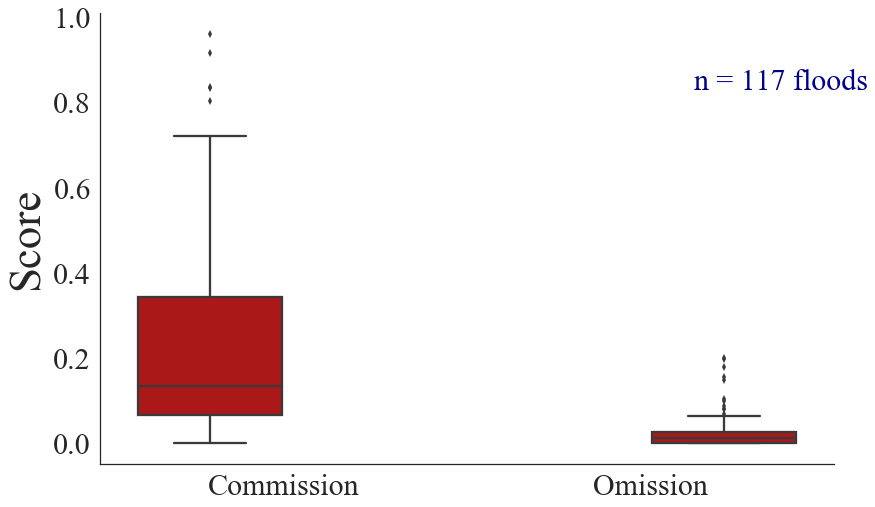

In [45]:
def set_style():
    plt.style.use(['seaborn-white', 'seaborn-talk'])
    plt.rc("font", family="Times New Roman", size = 30)
    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=30) 
set_style()  


g = sns.factorplot(kind='box',        # Boxplot
               y='value',       # Y-axis - values for boxplot
               x='Metric',        # X-axis - first factor
               hue = 'Metric',
               #order= metric,
               data=error,        # Dataframe 
               size=8,            # Figure size (x100px)      
               aspect=1.5, 
               palette= [ '#c30000','#c30000'],  # Width = size * aspect 
               legend_out=False)  # Make legend inside the plot
#g.fig.get_axes()[0].set_yscale('log')

g.fig.text(0.8, 0.8,'n = 117 floods', fontsize=30, color = 'darkblue') #add text

plt.ylabel('Score', fontsize = 45)
plt.xlabel('', fontsize = 45)
plt.title('', fontsize = 45)
#plt.axhline(y=0, color='grey', ls='--')
#plt.legend(loc='upper left', fontsize=45)

plt.show()

# %cd /Users/ckuhn/Desktop/gfd_accuracy_rename/figures/
# plt.savefig('GFD_error.png', dpi = 300)

In [46]:
# q = df.loc[df['NumofPoints'] == 199]
# x = df['NDVI'].values
# y = df['overall_accuracy'].values
# plt.plot(x, y, "o", color = 'green')